In [92]:
from astropy.table import Table
from astropy.io import fits
from astropy import units as u

import os

import matplotlib
import matplotlib.pyplot as plt

from scipy.integrate import trapezoid

import numpy as np
import pandas as pd

import tqdm

## Define filter sets

In [2]:
# Top-hat like filter transmission curve
def tophat_trans(x, center=0, fwhm=1, smoothness=0.2):

    from scipy.special import erf, erfc
    
    t_left  = erfc(+((2*(x-center)/fwhm)-1)/smoothness)/2 
    t_right = erfc(-((2*(x-center)/fwhm)+1)/smoothness)/2
    
    return (t_left*t_right)

### original filter sets w/o atmospheric effect

In [5]:
lambda_7ds = np.arange(4000., 9000., 250)
# flux_7ds = np.zeros_like(lambda_7ds)

filters_original = {}

for ii, wl_cen in enumerate(lambda_7ds):
    fwhm = 250
    wave_lvf = np.linspace(0.1, 1.0, 1001)
    resp_lvf = tophat_trans(wave_lvf, center=wl_cen/1e4, fwhm=fwhm/1e4)
    
    filters_original[f'wave_{wl_cen}'] = wave_lvf
    filters_original[f'resp_{wl_cen}'] = resp_lvf
    
#     flux_7ds[ii] = synth_phot(wl, f_nu, wave_lvf, resp_lvf)

# plt.xlim(0.3, 1.0)

In [7]:
# filters_original

### corrected filter sets w/ atmospheric effect & telescope characteristics

#### Detectors
- Assume quantum efficiency (QE) of the Gemini GMOS as an example

Text(0.5, 1.0, 'Gemini GMOS-N Hamamatsu CCD')

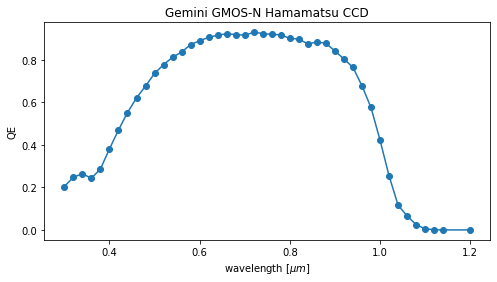

In [9]:
# QE table of Gemini GMOS-N Hamamatsu CCD
T_qe = Table.read('http://www.gemini.edu/sciops/instruments/gmos/gmos_n_ccd_hamamatsu_sc.txt', 
                  format='ascii.no_header', names=('wavelength', 'QE'))
T_qe['wavelength'] = T_qe['wavelength'].astype(float) * 1e-3
T_qe['wavelength'].unit = u.um
T_qe['wavelength'].format = '8.4f'

plt.figure(figsize=(8,4))
plt.plot(T_qe['wavelength'], T_qe['QE'], 'o-')
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('QE')
plt.title('Gemini GMOS-N Hamamatsu CCD')

#### efficiency

In [10]:
eff_mirrors = (0.92)**2  # Aluminium coating, 2 mirrors
eff_optics = 0.95        # Camera optics 
eff_LVF = 0.90           # LVF peak transmission (filter top transmission)
eff_fpa = 0.80           # Detector Quantum Efficiency (QE), nominal value

lambda_mid = 0.6
eff_fpa = np.interp(lambda_mid, T_qe['wavelength']/1000, T_qe['QE'])

eff_opt   = eff_mirrors * eff_optics * eff_LVF
eff_total = eff_opt * eff_fpa

eff_fpa, eff_opt, eff_total

(0.0, 0.723672, 0.0)

### Atmospheric transmission
- Site dependent!
- Model for Paranal site (VLT)
    - https://www.eso.org/sci/software/pipelines/skytools/skycalc
    - Run web-based calculator with 
        - `airmass = 1.3`
        - `PWV` = 2.5mm (very good, not critical in the optical)
        - `$\lambda_{min}$ =  300nm`
        - `$\lambda_{min}$ = 5000nm`
        - `Logarithmic binning` λ/Δλ = 20000 (default; decrease to save time and space)
        - Check `Calculate Broad-Band`

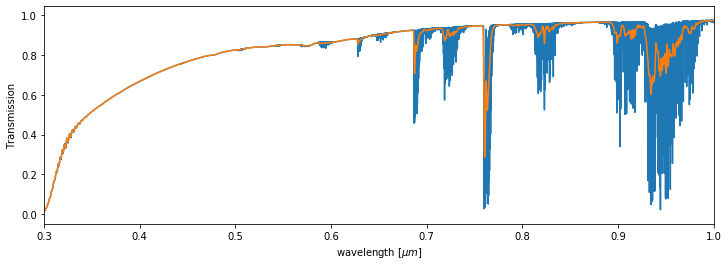

In [17]:
sky_tbl = Table.read('./22A_special_lecture/data/skytable.fits')

plt.figure(figsize=(12,4))
plt.plot(sky_tbl['lam']/1e3, sky_tbl['trans'])
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('Transmission')
plt.xlim(0.3, 1)

from scipy.ndimage import gaussian_filter
trans_smooth = gaussian_filter(sky_tbl['trans'], 10)
plt.plot(sky_tbl['lam']/1e3, trans_smooth)

In [19]:
filters_corrected = {}

for ii, wl_cen in enumerate(lambda_7ds):
    
    wave_lvf = filters_original[f'wave_{wl_cen}']
    resp_lvf = filters_original[f'resp_{wl_cen}']
    
    
    resp_sys = resp_lvf.copy()
    intp_qe = np.interp(wave_lvf, T_qe['wavelength'], T_qe['QE'])
    intp_trans = np.interp(wave_lvf, sky_tbl['lam']*1e-3, trans_smooth)
    
    resp_sys = resp_sys * intp_qe * intp_trans 
    resp_sys *= eff_mirrors * eff_optics
    
    filters_corrected[f'resp_{wl_cen}'] = resp_sys
    filters_corrected[f'wave_{wl_cen}'] = wave_lvf
    

In [43]:
colors = plt.cm.Spectral(np.linspace(1, 0, 20))

(0.3, 1)

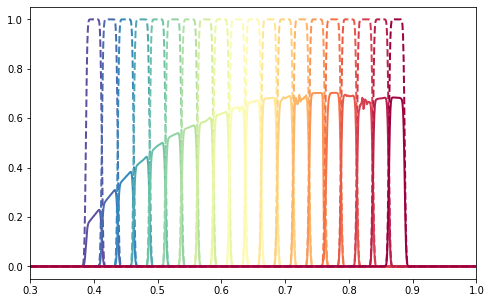

In [48]:
fig, ax = plt.subplots(figsize = (8, 5))

for ii, wl_cen in enumerate(lambda_7ds):
    
    wave_ori = filters_original[f'wave_{wl_cen}']
    resp_ori = filters_original[f'resp_{wl_cen}']
    
        
    wave_cor = filters_corrected[f'wave_{wl_cen}']
    resp_cor = filters_corrected[f'resp_{wl_cen}']
    
    ax.plot(wave_ori, resp_ori, color = colors[ii], linewidth = 2, linestyle = '--')
    ax.plot(wave_cor, resp_cor, color = colors[ii], linewidth = 2)
    
ax.set_xlim(0.3, 1)

# Synthetic photometry

In [54]:
# photometry function

def synth_phot(wave, flux, wave_lvf, resp_lvf, tol=1e-3):
    """
    Quick synthetic photometry routine.

    Parameters
    ----------
    wave : `numpy.ndarray`
        wavelength of input spectrum.
    flux : `numpy.ndarray`
        flux density of input spectrum in f_nu unit
    wave_lvf : `numpy.ndarray`
        wavelength of the response function
    resp_lvf : `numpy.ndarray`
        response function. assume that this is a QE.
    tol : float, optional
        Consider only wavelength range above this tolerence (peak * tol).
        The default is 1e-3.

    Returns
    -------
    Astropy.table with [wavelength, f_nu]
        wavelength is the center of the response function

    """
    index_filt, = np.where(resp_lvf > resp_lvf.max()*tol)

    index_flux, = np.where(np.logical_and( wave > wave_lvf[index_filt].min(), 
                                           wave < wave_lvf[index_filt].max() ))

    wave_resamp = np.concatenate( (wave[index_flux], wave_lvf[index_filt]) )
    wave_resamp.sort()
    wave_resamp = np.unique(wave_resamp)
    flux_resamp = np.interp(wave_resamp, wave, flux)
    resp_resamp = np.interp(wave_resamp, wave_lvf, resp_lvf)

    return trapezoid(resp_resamp / wave_resamp * flux_resamp, wave_resamp) \
         / trapezoid(resp_resamp / wave_resamp, wave_resamp)

In [51]:
plates = os.listdir('/data6/SDSSspec')
plates.sort()

plates = plates[:-1]
print(f'total {len(plates)} plates')

total 3809 plates


In [ ]:
for pl in tqdm.tqdm(plates[:1000]):
    
    spec_path = "/data6/SDSSspec/" + pl + "/"
    tbl_path = "/data6/SDSSspec_sup/" + pl + "/"
    
    specphot = pd.read_csv(tbl_path + 'specPhotoAll_' + pl + '.csv')
    
    gal_mask = specphot['class'] == 'GALAXY'
    specphot_gal = specphot[gal_mask]
    
    plate_fluxes = []
    
    for idx in range(len(specphot_gal)):
        
        cand = specphot_gal.iloc[idx]
        
        mjd = cand['mjd']
        fiberid = cand['fiberID']
        
        spec = Table.read(spec_path + 'spec-'+ pl + f'-{mjd:d}-' + f'{fiberid:04d}.fits')
        
        wl = 10**spec['loglam'] # Anstrom
        f_lambda = spec['flux'] * 1e-17 # erg/s/cm2/A

        f_nu = f_lambda * wl * (wl / 2.99792e18) / (1e-23 * 1e-6)  # micro Jansky
        wl = wl / 10000      # micron
        
        #synthetic photometry
        lambda_7ds = np.arange(4000., 9000., 250)
        flux_7ds = np.zeros_like(lambda_7ds, dtype = float)
        
        for ii, wl_cen in enumerate(lambda_7ds):
            
            wave_lvf = filters_corrected[f'wave_{wl_cen}']
            resp_lvf = filters_corrected[f'resp_{wl_cen}']
            
            flux_7ds[ii] = synth_phot(wl, f_nu, wave_lvf, resp_lvf)
        
        plate_fluxes.append(flux_7ds)
        
    
    plate_fluxes = np.array(plate_fluxes)
    
    # create table
    cols = []
    cols.append(np.array([int(pl)] * len(specphot_gal))) #plate
    cols.append(specphot[gal_mask]['mjd'].values) #mjd
    cols.append(specphot[gal_mask]['fiberID'].values) #fiberID
    
    names = ['plate', 'mjd', 'fiberid']
    for ii, wl_cen in enumerate(lambda_7ds):
        cols.append(plate_fluxes[:, ii])
        names.append(f'flux_{int(wl_cen):d}')
        
    tbl_synphot = Table(cols, names = names)
    tbl_synphot.write(tbl_path + 'synphot.csv', overwrite = True)

  6%|▌         | 56/1000 [07:15<1:44:46,  6.66s/it]

/usr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(array([ 5., 11.,  6.,  8., 13., 63., 62., 13.,  1.,  1.]),
 array([18.92433305, 19.49316528, 20.06199751, 20.63082974, 21.19966197,
        21.7684942 , 22.33732642, 22.90615865, 23.47499088, 24.04382311,
        24.61265534]),
 <a list of 10 Patch objects>)

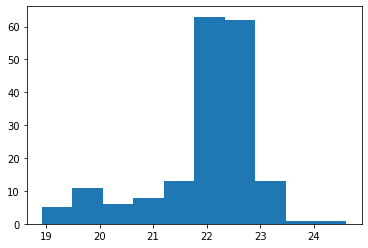

In [132]:
plt.hist(-2.5 * np.log10(tbl_synphot['flux_6000'] * 1e-6 * 1e-23) - 48.6)

In [124]:
f'flux_{int(wl_cen):d}'

'flux_4000'

In [107]:
# cand
specphot_gal.iloc[2]
# cand

specObjID     11259001129156237312
mjd                          58141
plate                        10000
tile                         16204
fiberID                          7
                      ...         
dered_r                    21.8251
dered_i                      20.62
dered_z                    19.6454
mjd_my                       58141
fiberid_my                       7
Name: 6, Length: 124, dtype: object

In [ ]:
spec = Table.read(spec_path + 'spec-'+ pl + f'-{mjd:d}-' + f'{fiberid:04d}.fits')

In [83]:
specphot[gal_mask]

,specObjID,mjd,plate,tile,fiberID,z,zErr,class,subClass,zWarning,...,extinction_i,extinction_z,fieldID,dered_u,dered_g,dered_r,dered_i,dered_z,mjd_my,fiberid_my
0,11258999485274281984,58462,10000,16204,1,0.606742,0.000219,GALAXY,NaN,0,...,0.095427,0.070980,1237680250561298432,24.28170,22.77911,21.30207,20.24133,19.44386,58462,1
3,11259000572270106624,57716,10000,16204,5,0.681351,0.000269,GALAXY,NaN,0,...,0.113744,0.084604,1237680250024493056,22.64131,22.77679,21.68160,20.58113,19.82677,57716,5
6,11259001129156237312,58141,10000,16204,7,0.834163,0.000332,GALAXY,NaN,0,...,0.095224,0.070829,1237680284389605376,22.33740,23.79659,21.82507,20.61998,19.64539,58141,7
13,11259004982832420864,58462,10000,16204,21,0.630744,0.000174,GALAXY,NaN,0,...,0.110419,0.082131,1237680250024427520,23.42980,22.48353,21.21381,20.18416,19.47416,58462,21
18,11259007181855676416,58462,10000,16204,29,0.597831,0.000181,GALAXY,NaN,0,...,0.094895,0.070584,1237680284389539840,23.10976,24.13372,21.49819,20.30204,19.55387,58462,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,11259264180182865920,57716,10000,16204,964,1.001368,0.000034,GALAXY,NaN,0,...,0.117959,0.087740,1237680251097907200,21.99529,21.63849,21.43376,21.17906,21.58493,57716,964
502,11259267760725972992,58141,10000,16204,977,0.626672,0.000303,GALAXY,NaN,0,...,0.114835,0.085416,1237680251098038272,26.16484,24.38251,21.84466,20.52616,19.87609,58141,977
506,11259270514890528768,58462,10000,16204,987,0.791346,0.000354,GALAXY,NaN,0,...,0.112365,0.083579,1237680285463216128,25.59473,23.76091,21.82335,20.62923,19.83653,58462,987
508,11259271601886353408,57716,10000,16204,991,0.611011,0.000294,GALAXY,NaN,0,...,0.115002,0.085541,1237680285463281664,23.53044,24.10798,21.30738,20.19014,19.48421,57716,991


(array([19., 12., 24., 85., 34.,  3.,  3.,  0.,  3.,  1.]),
 array([-7.56316600e-04,  1.96118615e-01,  3.92993547e-01,  5.89868478e-01,
         7.86743410e-01,  9.83618342e-01,  1.18049327e+00,  1.37736821e+00,
         1.57424314e+00,  1.77111807e+00,  1.96799300e+00]),
 <a list of 10 Patch objects>)

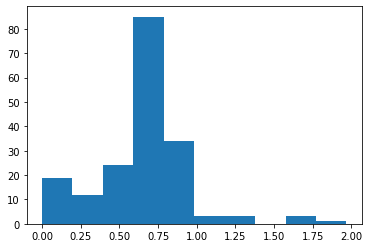

In [66]:
plt.hist(specphot[gal_mask]['z'])

How to calculate flux-uncertainty from photometry? ([ref](https://wise2.ipac.caltech.edu/staff/fmasci/ApPhotUncert.pdf))

- $1-\sigma$ uncertainty (square roote of noise variance)
- assumption: no severe pixel-to-pixel correlations

$\sigma^{2}_{src} = \frac{1}{g}\sum_{i}^{N_{A}}\frac{(S_{i} - \bar{B})}{N_{i}} + (N_{A} + k\frac{N^{2}_{A}}{N_{B}})\times \sigma^{2}_{B/pix}$

- $g$: gain in electrons/pixel data units
- $N_{A}$: number of pixels in source aperture
- $N_{B}$: number of pixels in background annulus
- $N_{i}$: depth of coverage at pixel i
- $S_{i}$: signal in pixel in i in image data units
